In [1]:
import re
import string
import unicodedata
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy.sparse import hstack

import contractions

import nltk
from nltk.corpus import stopwords

import spacy

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

from sklearn import (
    linear_model,
    feature_extraction,
    model_selection,
    naive_bayes,
    metrics,
    ensemble,
)

import pyLDAvis
import pyLDAvis.gensim_models

import hypopt
import seaborn as sns


c:\Users\yagne\anaconda3\envs\common\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\yagne\anaconda3\envs\common\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
data = pd.read_csv("data/final_all_data.csv")
data["full_text"] = data.apply(lambda x: x["title"] + " " + x["selftext"], axis=1)
# Drop strange subreddit that is very represented in the data but has only 4.2k members.
# data = data.loc[data["subreddit"] != "randonaut_reports"].reset_index(drop=True)

# Drop any leakage in the data from depression-related subreddits
data = data.loc[
    ~data["subreddit"].isin(
        [
            "randonaut_reports",
            "depression",
            "SuicideWatch",
            "depression_help",
            "depressed",
        ]
    )
].reset_index(drop=True)

data.shape



(104061, 11)

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    data["full_text"], data["depression"], test_size=0.10, random_state=42
)
X_train, X_val, y_train, y_val = model_selection.train_test_split(
    X_train, y_train, test_size=0.10, random_state=42
)

print("Train, Val, Test Sizes")
print(y_train.shape, y_val.shape, y_test.shape)


Train, Val, Test Sizes
(84288,) (9366,) (10407,)


In [4]:
all_text = " ".join(X_train).split(" ")
n_tokens = len(all_text)
n_types = len(set(all_text))
print("Tokens:", n_tokens)
print("Types: ", n_types)
print("Type-Token Ratio:", round(n_types/n_tokens,4))

Tokens: 10656781
Types:  484587
Type-Token Ratio: 0.0455


In [6]:
translate_table = dict((ord(char), None) for char in string.punctuation + "‘’")
# Pre-processing code comes from modification of Gensim's simple_tokenize to include numbers and remove punctuation
# https://github.com/RaRe-Technologies/gensim/blob/351456b4f7d597e5a4522e71acedf785b2128ca1/gensim/utils.py#L288


def to_unicode(text):
    if isinstance(text, str):
        return text.encode("latin", "ignore").decode("utf-8", "ignore")
    a = str(text, "ut8")
    return a.encode("latin", "ignore").decode("utf-8", "ignore")

def preprocess(text):
    text = to_unicode(text)
    if lowercase:
        text = text.lower()

    if deaccent:
        text = unicodedata.normalize("NFD", text)
        text = "".join(ch for ch in text if unicodedata.category(ch) != "Mn")
        text = unicodedata.normalize("NFC", text)

    # Remove extra white space
    text = re.sub(r'\s+', ' ', text)


    # Remove /r/depression
    if remove_leaks:
        text = re.sub(r"\/?r\/?depression", "", text)
    # Remove URL
    if remove_urls:
        text = re.sub(r"https?:\/\/\S+", "", text)

    if remove_reddit_chars:
        text = re.sub(r"\/r\/|\/u\/", "", text)

    if expand_contractions:
        text = contractions.fix(text)

    # Remove punctuation
    if remove_punctuation:
        text = text.replace("-", " ")
        text = text.translate(translate_table)

    text = text.split()

    if remove_numbers:
        text = [w for w in text if w.isalpha()]

    return [token for token in text if min_len <= len(token) and max_len >= len(token)]


min_len = 2
max_len = 15

lowercase = True
deaccent = True
remove_leaks = True
remove_urls = True
remove_reddit_chars = True
expand_contractions = True
remove_punctuation = True
remove_numbers = True


In [222]:
# X_train_clean = list(map(preprocess, X_train))
# X_val_clean = list(map(preprocess, X_val))
# X_test_clean = list(map(preprocess, X_test))


In [7]:
data["cleaned_text"] = list(map(preprocess, data["full_text"]))
data["clean_length"] = data["cleaned_text"].apply(len)

In [9]:
data = data.loc[data["clean_length"] > 30].reset_index(drop=True)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    data["cleaned_text"], data["depression"], test_size=0.10, random_state=42
)
X_train, X_val, y_train, y_val = model_selection.train_test_split(
    X_train, y_train, test_size=0.10, random_state=42
)

print("Train, Val, Test Sizes")
print(y_train.shape, y_val.shape, y_test.shape)

Train, Val, Test Sizes
(83818,) (9314,) (10348,)


In [10]:
all_text = " ".join([" ".join(text) for text in X_train]).split(" ")
n_tokens = len(all_text)
n_types = len(set(all_text))
print("Tokens:", n_tokens)
print("Types: ", n_types)
print("Type-Token Ratio:", round(n_types/n_tokens,4))

Tokens: 9998705
Types:  123505
Type-Token Ratio: 0.0124


In [11]:
data.shape

(103480, 13)

# N-grams

In [12]:
# Drop any terms that do not appear in at least 0.1% of documents
min_docfreq = int(X_train.shape[0] * 0.0005)
print("Min Doc Frequency: ", min_docfreq)
ngram_threshold = 1


bigram = Phrases(
    X_train,
    min_count=min_docfreq,
    threshold=ngram_threshold,
    connector_words=ENGLISH_CONNECTOR_WORDS,
)
bigram_mod = gensim.models.phrases.Phraser(bigram)

moregram = Phrases(
    bigram[X_train],
    min_count=min_docfreq,
    threshold=ngram_threshold,
    connector_words=ENGLISH_CONNECTOR_WORDS,
)
moregram_mod = gensim.models.phrases.Phraser(moregram)

len(bigram_mod.phrasegrams),len(moregram_mod.phrasegrams)

Min Doc Frequency:  41


(6300, 8236)

In [13]:
X_train_ngram_mod = moregram_mod[X_train]
X_val_ngram_mod = moregram_mod[X_val]
X_test_ngram_mod = moregram_mod[X_test]
X_train_ngram = [t for t in X_train_ngram_mod]
X_val_ngram = [t for t in X_val_ngram_mod]
X_test_ngram = [t for t in X_test_ngram_mod]


In [14]:
all_text = " ".join([" ".join(text) for text in X_train_ngram]).split(" ")
n_tokens = len(all_text)
n_types = len(set(all_text))
print("Tokens:", n_tokens)
print("Types: ", n_types)
print("Type-Token Ratio:", round(n_types/n_tokens,4))

Tokens: 8159236
Types:  130621
Type-Token Ratio: 0.016


# Remove Stop Words

In [15]:
my_stopwords = stopwords.words("english")  # Common terms that did not seem helpful.


def remove_stopwords(str_):
    if str_ in my_stopwords:
        return False
    return True


stopless_text = [list(filter(remove_stopwords, t)) for t in X_train_ngram]

In [16]:
all_text = []
for t in stopless_text:
    all_text.extend(t)
c = Counter(all_text)
print([x[0] for x in c.most_common()[:100]])


['do_not', 'like', 'it_is', 'get', 'one', 'know', 'people', 'have_been', 'time', 'really', 'that_is', 'even', 'also', 'work', 'want', 'something', 'it_was', 'this_is', 'if_you', 'did_not', 'there_is', 'got', 'back', 'go', 'think', 'good', 'am_not', 'feel_like', 'new', 'things', 'love', 'life', 'lot', 'feel', 'does_not', 'game', 'going', 'around', 'day', 'anything', 'help', 'way', 'without', 'still', 'someone', 'would', 'you_are', 'since', 'getting', 'everything', 'but_am', 'need', 'first', 'us', 'is_not', 'today', 'but_it', 'use', 'see', 'maybe', 'never', 'take', 'friends', 'they_are', 'would_be', 'looking', 'years', 'make', 'what_is', 'right', 'always', 'well', 'better', 'try', 'she_is', 'start', 'so_much', 'person', 'kind', 'actually', 'my_life', 'school', 'play', 'bad', 'little', 'say', 'right_now', 'two', 'will_be', 'how_do', 'know_what', 'live', 'different', 'is_it', 'used', 'ever', 'another', 'feeling', 'best', 'job']


In [17]:
## Manually selected from every common terms that do not seem to provide too much information
extra_stopwords = [
    "do_not",
    "it_is",
    "like",
    "get",
    "one",
    "know",
    "have_been",
    "really",
    "that_is",
    "work",
    "also",
    "even",
    "want",
    "something",
    "this_is",
    "it_was",
    "did_not",
    "if_you",
    "there_is",
    "got",
    "back",
    "go",
    "new",
    "am_not",
    "things",
    "lot",
    "going",
    "does_not",
    "around",
    "would",
    "day",
    "anything",
    "way",
    "someone",
    "but_it",
    "still",
    "without",
    "since",
    "you_are",
    "ampx200b",
    "getting",
    "is_not",
    "need",
    "first",
    "everything",
    "us",
    "but_am",
    "would_be",
    "right",
    "see",
    "take",
    "use",
    "they_are",
    "make",
    "always",
    "what_is",
    "try",
    "looking",
    "maybe",
    "well",
    "start",
    "will_be",
    "so_much",
    "say",
    "actually" "two",
    "how_do",
    "is_it",
    "know_what",
    "another",
]


In [269]:
1+1

2

In [18]:
my_stopwords = stopwords.words("english") + extra_stopwords


def remove_stopwords(str_):
    if str_ in my_stopwords:
        return False
    return True


X_train_stopless = [list(filter(remove_stopwords, t)) for t in X_train_ngram]
X_val_stopless = [list(filter(remove_stopwords, t)) for t in X_val_ngram]
X_test_stopless = [list(filter(remove_stopwords, t)) for t in X_test_ngram]


# Lemmatize

In [19]:
def self_lemmatize(str_list):
    spacy_out = nlp(" ".join(str_list))
    lemma_out = [token.lemma_ for token in spacy_out]
    return lemma_out


In [20]:
X_train_lemma = [self_lemmatize(l) for l in X_train_stopless]
X_val_lemma = [self_lemmatize(l) for l in X_val_stopless]
X_test_lemma = [self_lemmatize(l) for l in X_test_stopless]


In [21]:
all_text = " ".join([" ".join(text) for text in X_train_lemma]).split(" ")
n_tokens = len(all_text)
n_types = len(set(all_text))
print("Tokens:", n_tokens)
print("Types: ", n_types)
print("Type-Token Ratio:", round(n_types/n_tokens,4))

Tokens: 4852132
Types:  118121
Type-Token Ratio: 0.0243


In [22]:
len(X_train_lemma)

83818

In [33]:
train_clean = pd.DataFrame(data = {"real_index": X_train.index, "cleaned_text2": X_train_lemma})
train_clean["split"] = "train"
val_clean = pd.DataFrame(data = {"real_index": X_val.index, "cleaned_text2": X_val_lemma})
val_clean["split"] = "val"
test_clean = pd.DataFrame(data = {"real_index": X_test.index, "cleaned_text2": X_test_lemma})
test_clean["split"] = "test"

# # FINAL CLEAN BECAUSE WHY DO YOU STILL MAKE IT IN THE DATASET
train_clean["cleaned_text2"] = train_clean["cleaned_text2"].apply(lambda x: [w for w in x if w != '"'])
val_clean["cleaned_text2"] = val_clean["cleaned_text2"].apply(lambda x: [w for w in x if w != '"'])
test_clean["cleaned_text2"] = test_clean["cleaned_text2"].apply(lambda x: [w for w in x if w != '"'])

In [34]:
train_clean

,real_index,cleaned_text2,split
0,8287,"[weird, women, shampoo, accidentally, use, few...",train
1,68704,"[masturbation, competition, tm, crowd, cheer, ...",train
2,54694,"[pretty_sure, am_bee, irrational, somehow, con...",train
3,20205,"[cuddle, middle, tennessee, nashville, smyrna,...",train
4,54926,"[ask, my_crush, prom, she_said, yes, have_had,...",train
...,...,...,...
83813,32020,"[when_you, open, vscode, open, where_you, leav...",train
83814,39903,"[anohana, nagi, asukara, lull, sea, finish, wa...",train
83815,7222,"[start, season, am_glad, watched_it, this_way,...",train
83816,30626,"[where_can, find, list, games_that, skill, bas...",train


In [35]:

cleaned_df = pd.concat([train_clean,val_clean,test_clean])
cleaned_df = cleaned_df.sort_values("real_index").reset_index(drop=True)
cleaned_df["cleaned_text2"] = cleaned_df["cleaned_text2"].apply(lambda x: " ".join(x))

In [36]:
data_new = pd.concat([data, cleaned_df[["split", "cleaned_text2"]]],axis =1)
data_new["cleaned_text"] = data_new["cleaned_text"].apply(lambda x: " ".join(x))

In [37]:
data_new.to_csv("data/redo_clean.csv", index=False)

# LDA

In [277]:
id2word = corpora.Dictionary(X_train_lemma)
train_corpus = [id2word.doc2bow(text) for text in X_train_lemma]
val_corpus = [id2word.doc2bow(text) for text in X_val_lemma]
test_corpus = [id2word.doc2bow(text) for text in X_test_lemma]
print(train_corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 2), (14, 1)]


## Tuning

In [203]:
alphas = np.arange(0.1,2.1,step=0.2)
topics = np.arange(10,101,step=10)

In [206]:
tracker = []

for a in alphas:
    for t in topics:
        print(a,t)

        lda_model = gensim.models.ldamulticore.LdaMulticore(
            corpus=train_corpus,
            id2word=id2word,
            num_topics=t, 
            random_state=100,
            workers=5,
            passes=1,
            alpha=a,
            per_word_topics=True
        )

        val_perp = lda_model.log_perplexity(val_corpus)
        val_coh_mod = CoherenceModel(model=lda_model, texts=X_val_lemma, dictionary=id2word, coherence='c_v')
        val_coh = val_coh_mod.get_coherence() 
        tracker.append({
            "alpha": a,
            "topic": t,
            "val_perplexity": val_perp,
            "val_coherence": val_coh

        })

0.1 10
0.1 20
0.1 30
0.1 40
0.1 50


c:\Users\yagne\anaconda3\envs\common\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
c:\Users\yagne\anaconda3\envs\common\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


0.1 60
0.1 70
0.1 80
0.1 90
0.1 100
0.30000000000000004 10
0.30000000000000004 20
0.30000000000000004 30
0.30000000000000004 40
0.30000000000000004 50
0.30000000000000004 60
0.30000000000000004 70
0.30000000000000004 80
0.30000000000000004 90
0.30000000000000004 100
0.5000000000000001 10
0.5000000000000001 20
0.5000000000000001 30
0.5000000000000001 40
0.5000000000000001 50
0.5000000000000001 60
0.5000000000000001 70
0.5000000000000001 80
0.5000000000000001 90
0.5000000000000001 100
0.7000000000000001 10
0.7000000000000001 20
0.7000000000000001 30
0.7000000000000001 40
0.7000000000000001 50
0.7000000000000001 60
0.7000000000000001 70
0.7000000000000001 80
0.7000000000000001 90
0.7000000000000001 100
0.9000000000000001 10
0.9000000000000001 20
0.9000000000000001 30
0.9000000000000001 40
0.9000000000000001 50
0.9000000000000001 60
0.9000000000000001 70
0.9000000000000001 80
0.9000000000000001 90
0.9000000000000001 100
1.1000000000000003 10
1.1000000000000003 20
1.1000000000000003 30
1.10

In [207]:
tracker_df = pd.DataFrame(tracker)
tracker_df.to_csv("lda_tuning.csv", index=False)

In [208]:
tracker_df

,alpha,topic,val_perplexity,val_coherence
0,0.1,10,-10.796793,0.371336
1,0.1,20,-11.828796,0.319316
2,0.1,30,-12.756584,0.322661
3,0.1,40,-13.606165,0.348777
4,0.1,50,-14.332785,NaN
...,...,...,...,...
95,1.9,60,-19.148492,NaN
96,1.9,70,-20.694245,NaN
97,1.9,80,-22.175057,NaN
98,1.9,90,-24.037126,NaN


<AxesSubplot:xlabel='topic', ylabel='alpha'>

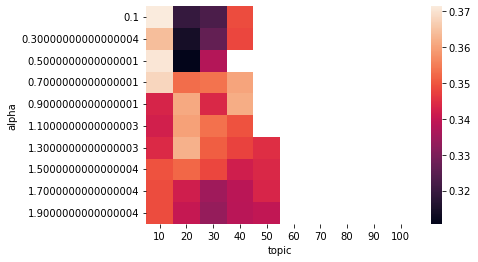

In [209]:
sns.heatmap(tracker_df.pivot(index="alpha", columns="topic", values="val_coherence"))

In [280]:
lda_model = gensim.models.ldamulticore.LdaMulticore(
            corpus=train_corpus,
            id2word=id2word,
            num_topics=20, 
            random_state=100,
            workers=5,
            passes=3,
            alpha=1.0,
            per_word_topics=True
        )

In [281]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, train_corpus, id2word)
vis


c:\Users\yagne\anaconda3\envs\common\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.120153 -0.005520       1        1  12.302141
4      0.071448  0.024584       2        1   8.680483
17     0.054334 -0.018651       3        1   7.294268
15    -0.053450  0.033205       4        1   6.859695
14    -0.083020  0.065148       5        1   5.834026
1      0.018875  0.002993       6        1   5.185703
6      0.033195 -0.002933       7        1   5.002096
3     -0.036570  0.017739       8        1   4.738024
5     -0.047710  0.012439       9        1   4.506693
10     0.030820  0.006211      10        1   4.347175
11    -0.015462  0.009839      11        1   4.319360
0     -0.008257  0.011808      12        1   3.978858
9     -0.014755  0.010607      13        1   3.773681
2      0.006558  0.005028      14        1   3.663430
13     0.008156 -0.039179      15        1   3.490882
18    -0.014580 -0.001035      16        1   3.405371
7     -0.005493  0.010621      17        1   3.375042
16    -0.005203  0.014883      18        1   3.324102
19    -0.066188 -0.138219      19        1   3.040970
12     0.007149 -0.019569      20        1   2.877998, topic_info=        Term          Freq         Total Category  logprob  loglift
1608   music   3149.000000   3149.000000  Default  30.0000  30.0000
183     game  10129.000000  10129.000000  Default  29.0000  29.0000
4452  assist   1553.000000   1553.000000  Default  28.0000  28.0000
1305     god   3115.000000   3115.000000  Default  27.0000  27.0000
1319    play   8559.000000   8559.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
9484  stream    331.404761    553.249098  Topic20  -6.0435   3.0356
4123  afraid    341.639641   1138.166310  Topic20  -6.0131   2.3447
472    think    330.890886  12696.864605  Topic20  -6.0451  -0.0992
1425   state    321.986945   2620.338399  Topic20  -6.0723   1.4515
864   not_be    317.961356   1516.356405  Topic20  -6.0849   1.9859

[1802 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
32064      4  0.911167      aang
15922      9  0.013506    aatrox
15922     16  0.931911    aatrox
16994     15  0.964665      aber
376        1  0.355426  about_it
...      ...       ...       ...
11242     18  0.014578    zoloft
11242     19  0.008747    zoloft
11242     20  0.026240    zoloft
16792      9  0.949369       zss
12759     15  0.960132        zu

[14790 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 18, 16, 15, 2, 7, 4, 6, 11, 12, 1, 10, 3, 14, 19, 8, 17, 20, 13])